# The National Parks Dataset for Tidy Tuesday!

Here is some great information about today's dataset!  

> The information in NPSpecies is available to the public. The exceptions to this are records for some sensitive, threatened, or endangered species, where widespread distribution of information could potentially put a species at risk.  
>
> An essential component of NPSpecies is evidence; that is, observations, vouchers, or reports that document the presence of a species in a park. Ideally, every species in a park that is designated as “present in park” will have at least one form of credible evidence substantiating the designation

Thanks to [f.hull](https://github.com/frankiethull) for putting the dataset together.  

Access the data and more, here! --> [link](https://github.com/rfordatascience/tidytuesday/blob/504d69514fc162bb6fb76a9ffd356941330f0df9/data/2024/2024-10-08/readme.md)



## Setup

In [1]:
# installation
using Pkg
Pkg.add(["DataFrames", "CSV", "HTTP", "StatsPlots",
    "StatsBase", "Plots", "SummaryTables", "DataFramesMeta",
    "Chain", "CategoricalArrays", "Measures", "PlotThemes",
    "SplitApplyCombine"
])

# load
using DataFrames, CSV, HTTP, StatsPlots, StatsBase, Plots, SummaryTables, DataFramesMeta, Chain, CategoricalArrays, Measures, PlotThemes, SplitApplyCombine

   Resolving package versions...
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ndfos\.julia\environments\v1.10\Manifest.toml`


## Data

In [2]:
# Option 1: Fetch data directly from GitHub
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-10-08/most_visited_nps_species_data.csv"
 
response = HTTP.get(url)

# Parse the CSV into a DataFrame
species_data = CSV.read(response.body, DataFrame)

# Verify the first few rows
first(species_data, 5)


Row,ParkCode,ParkName,CategoryName,Order,Family,TaxonRecordStatus,SciName,CommonNames,Synonyms,ParkAccepted,Sensitive,RecordStatus,Occurrence,OccurrenceTags,Nativeness,NativenessTags,Abundance,NPSTags,ParkTags,References,Observations,Vouchers,ExternalLinks,TEStatus,StateStatus,OzoneSensitiveStatus,GRank,SRank
,String7,String,String31,String31,String31,String15,String,String,Missing,Bool,Bool,String15,String31,String31,String15,String31,String15,String,String,Int64,Int64,Int64,String,String7,String,String7,String15,String
1,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Alces alces,Moose,missing,true,false,Approved,Present,NA,Native,NA,Rare,Resident,NA,11,1,0,NA,50,NA,NA,G5,ME: S5
2,ACAD,Acadia National Park,Mammal,Artiodactyla,Cervidae,Active,Odocoileus virginianus,"Northern White-tailed Deer, Virginia Deer, White-tailed Deer",missing,true,false,Approved,Present,NA,Native,NA,Abundant,NA,NA,20,0,0,NA,50,NA,NA,G5,ME: S5
3,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis latrans,"Coyote, Eastern Coyote",missing,true,false,Approved,Present,NA,Non-native,NA,Common,NA,NA,8,1,0,NA,SC,NA,NA,G5,ME: S5
4,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Canis lupus,"Eastern Timber Wolf, Gray Wolf, Timber Wolf",missing,true,false,Approved,Unconfirmed,NA,Native,NA,NA,NA,NA,2,0,0,NA,E,NA,NA,G5,ME: SH
5,ACAD,Acadia National Park,Mammal,Carnivora,Canidae,Active,Vulpes vulpes,"Black Fox, Cross Fox, Eastern Red Fox, Fox, Red Fox, Silver Fox",missing,true,false,Approved,Present,NA,Unknown,NA,Common,Breeder,NA,16,0,0,NA,NA,NA,NA,G5,ME: S5


In [3]:
# check the category name variable to see unique values
unique(species_data.CategoryName)

16-element Vector{String31}:
 "Mammal"
 "Bird"
 "Reptile"
 "Amphibian"
 "Fish"
 "Vascular Plant"
 "Crab/Lobster/Shrimp"
 "Slug/Snail"
 "Spider/Scorpion"
 "Insect"
 "Other Non-vertebrates"
 "Non-vascular Plant"
 "Fungi"
 "Chromista"
 "Protozoa"
 "Bacteria"

In [4]:
# check the data

describe(species_data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,ParkCode,,ACAD,,ZION,0,String7
2,ParkName,,Acadia National Park,,Zion National Park,0,String
3,CategoryName,,Amphibian,,Vascular Plant,0,String31
4,Order,,Acari,,Zygophyllales,0,String31
5,Family,,Abacionidae,,Zygophyllaceae,0,String31
6,TaxonRecordStatus,,Active,,Inactive,0,String15
7,SciName,,Aaptolasma,,ulocladium,0,String
8,CommonNames,,Finespotted Snake River cutthroat trout,,‘Nevada’ Silver-spotted Skipper,0,String
9,Synonyms,,,,,61119,Missing


## Steps for the Analysis:
* Filter the dataset: Focus on the 15 most visited parks and ensure we capture relevant columns like `ParkName`, `Abundance`, and `Nativeness`.
* Group and summarize: We'll summarize the abundance of species for each park, grouped by nativeness (native vs non-native).
* Create a stacked bar chart: We'll visualize species abundance by park, stacking native and non-native species for easy comparison.

## Code to Filter and Summarize:

In [75]:
# get a dataframe with CommonNames and the CategoryName for a join
common_names_categories = @chain begin
    species_data
    filter(:CategoryName => x -> x in ["Mammal", "Bird", "Reptile", "Amphibian", "Fish", "Insect"], _)
    @transform(:CommonNames = ifelse.(:CommonNames .== "NA", :SciName, :CommonNames))
    @transform(:CommonNames = ifelse.(occursin.(",", :CommonNames), first.(split.(:CommonNames, ",")), :CommonNames))  # Handle split only if comma exists
    select(:CommonNames, :CategoryName)
    unique(_)
end

# Filter and summarize data using @chain macro
# get the most documented species in each park
species_abundance_summary = @chain begin
    species_data
    filter(:CategoryName => x -> x in ["Mammal", "Bird", "Reptile", "Amphibian", "Fish", "Insect"], _)
    @transform(:CommonNames = ifelse.(:CommonNames .== "NA", :SciName, :CommonNames))
    @transform(:CommonNames = ifelse.(occursin.(",", :CommonNames), first.(split.(:CommonNames, ",")), :CommonNames))  # Handle split only if comma exists
    groupby([:ParkName, :CommonNames])
    @combine(:Total_Documentation = :Vouchers .+ :Observations .+ :References; ungroup=true)
    sort([:ParkName, order(:Total_Documentation, rev=true)])
    groupby(:ParkName)
    subset(:Total_Documentation => x -> x .== maximum(x))
    groupby(:ParkName)
    combine(:ParkName => first => :ParkName, :CommonNames => first => :CommonNames, :Total_Documentation => first => :Total_Documentation)  # Combine with max sightings per ParkName
    leftjoin(common_names_categories, on = :CommonNames)
    select(:ParkName, :CategoryName, :CommonNames, :Total_Documentation)
    sort(:Total_Documentation, rev = true)
end

species_abundance_summary.ParkName = categorical(species_abundance_summary.ParkName, levels=unique(species_abundance_summary.ParkName), ordered = true)

species_abundance_summary

Row,ParkName,CategoryName,CommonNames,Total_Documentation
,Cat…,String31?,Abstract…,Int64
1,Great Smoky Mountains National Park,Amphibian,Red-cheeked Salamander,11240
2,Yosemite National Park,Bird,Oregon junco,1429
3,Joshua Tree National Park,Reptile,desert tortoise,976
4,Rocky Mountain National Park,Bird,American Robin,714
5,Grand Teton National Park,Bird,Bald Eagle,621
6,Grand Canyon National Park,Mammal,Cactus Deermouse,546
7,Yellowstone National Park,Bird,Trumpeter Swan,439
8,Bryce Canyon National Park,Mammal,Deer Mouse,386
9,Olympic National Park,Mammal,white-footed mouse,205


## Visualize

### Stacked Bar Chart:

Once we have the summarized data, we can create the stacked bar chart.

This will produce a stacked bar chart where each bar represents a park, and the native/non-native species are stacked to show their total contributions.

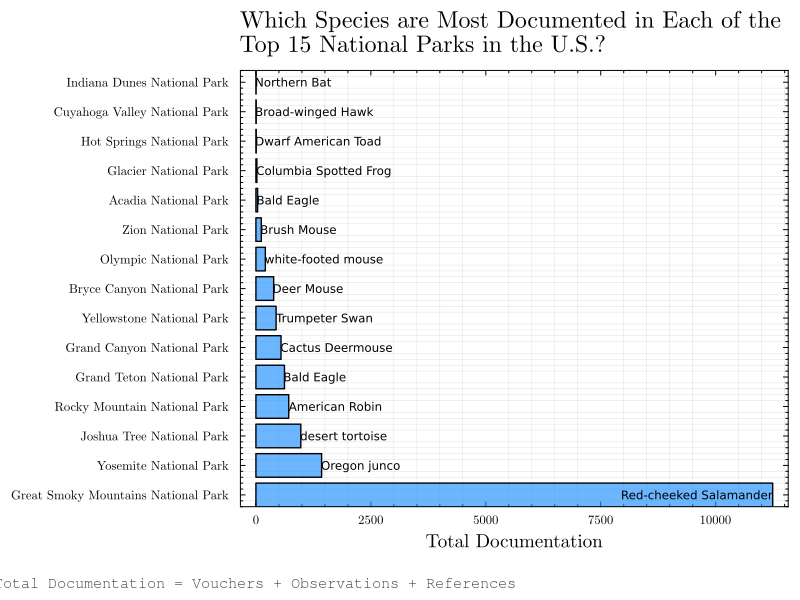

In [180]:
# Stacked bar chart for species abundance by park and nativeness
theme(:dao)
species_abundance_bar = @df species_abundance_summary bar(:ParkName, :Total_Documentation,
        title = "Which Species are Most Documented in Each of the\nTop 15 National Parks in the U.S.?\n", xlabel = "", ylabel = "Total Documentation",
        legend = false, fill = "dodgerblue", fillalpha = 0.65, titlefontsize = 15, titlealign = :left, permute = (:x, :y), size = (800, 600),
    grid=false, text=text.(:CommonNames, 8, [:right, :left, :left, :left, :left, :left, :left, :left, :left, :left, :left, :left, :left, :left, :left]), bottom_margin = 12mm
        )
annotate!(-2, -2, text("Total Documentation = Vouchers + Observations + References", "sans serif", :center, 8))

### Explanation:

* `@chain`: Ensures a more readable pipeline for processing the data.
* Data Processing: We:
    * Select only relevant columns (`ParkName`, `Abundance`, `Nativeness`).
    * Drop missing data.
    * Group the data by park name and nativeness.
    * Count the number of species in each group.
* Plotting: We use the `groupedbar` function to create a stacked bar chart with native and non-native species counts per park.

## Analysis Overview
1. Data Preparation:

    * Filtering by Categories: We filtered the dataset to include only relevant species categories: Mammal, Bird, Reptile, Amphibian, Fish, and Insect.
    * Handling Missing and Multiple Common Names:
    * Replaced missing common names with scientific names.
    * If a species had multiple common names separated by commas, we selected the first name.
    * Unique Species: We selected unique combinations of CommonNames and CategoryName for further analysis.

2. Summarizing Species Documentation:

    * Filtering Relevant Species: We repeated the category and common name filtering steps to ensure consistency.
    * Grouping by Park and Species: Grouped data by park and species, then calculated the total documentation count (sum of vouchers, observations, and references).
    * Sorting by Documentation: Sorted species data within each park by the total number of documentations.
    * Selecting Top Documented Species: For each park, we selected the species with the maximum documentation count.
    * Joining with Categories: Merged the top species data with category names for classification.

3. Data Visualization:

    * Creating a Stacked Bar Chart: Using a stacked bar chart to visualize the total documentation of the most frequently documented species per park.
    * Bar Labels: Each bar is labeled with the species' common name.
    * Annotating the Plot: An additional annotation below the plot explains that total documentation is the sum of vouchers, observations, and references.